# Kalman filter

In [18]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from cycler import cycler
from functools import partial
from rebayes_mini.methods import kalman_filter as kf

In [19]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
plt.style.use('dark_background')

In [21]:
acolors = [
    "#D9117F",
    "#0DD9D9",
    "#F2A30F",
    "#F26E22",
]

# plt.rcParams["axes.prop_cycle"] = cycler(color=colors)
colors = list(v["color"] for v in plt.rcParams["axes.prop_cycle"])

In [22]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Based on
* https://github.com/probml/dynamax/blob/main/docs/notebooks/linear_gaussian_ssm/kf_tracking.ipynb

In [23]:
def step_ssm(z, key, transition, projection, latent_cov, obs_cov):
    key_latent, key_obs = jax.random.split(key)
    d_obs, d_latent = projection.shape
    
    z_next = transition @ z
    z_next = jax.random.multivariate_normal(key_latent, z_next, latent_cov)
    
    obs_next = projection @ z_next
    obs_next = jax.random.multivariate_normal(key_obs, obs_next, obs_cov)
    
    return z_next, (z_next, obs_next)
    

def sample_ssm(key, z0, steps, transition, projection, latent_cov, obs_cov):
    _step = partial(step_ssm,
        transition=transition,
        projection=projection,
        latent_cov=latent_cov,
        obs_cov=obs_cov
    )
    keys = jax.random.split(key, steps)
    _, (z_hist, obs_hist) = jax.lax.scan(_step, z0, keys)
    return z_hist, obs_hist

In [25]:
state_dim = 4
emission_dim = 2

# Manually chosen parameters
initial_mean = jnp.array([8.0, 10.0, 1.0, 0.0])

delta = 1.0
initial_covariance = 0.1

dynamics_weights  = jnp.array([[1, 0, delta, 0],
                               [0, 1, 0, delta],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])


dynamics_covariance = jnp.eye(state_dim) * 0.001


emission_weights = jnp.array([[1.0, 0, 0, 0],
                              [0, 1.0, 0, 0]])

emission_covariance = jnp.eye(emission_dim) * 1.0

## Sample state

In [26]:
key = jax.random.PRNGKey(0)
n_steps = 100
latent_hist, obs_hist = sample_ssm(
    key, initial_mean, n_steps, dynamics_weights, emission_weights, dynamics_covariance, emission_covariance
)

In [27]:
xrange = jnp.arange(n_steps)

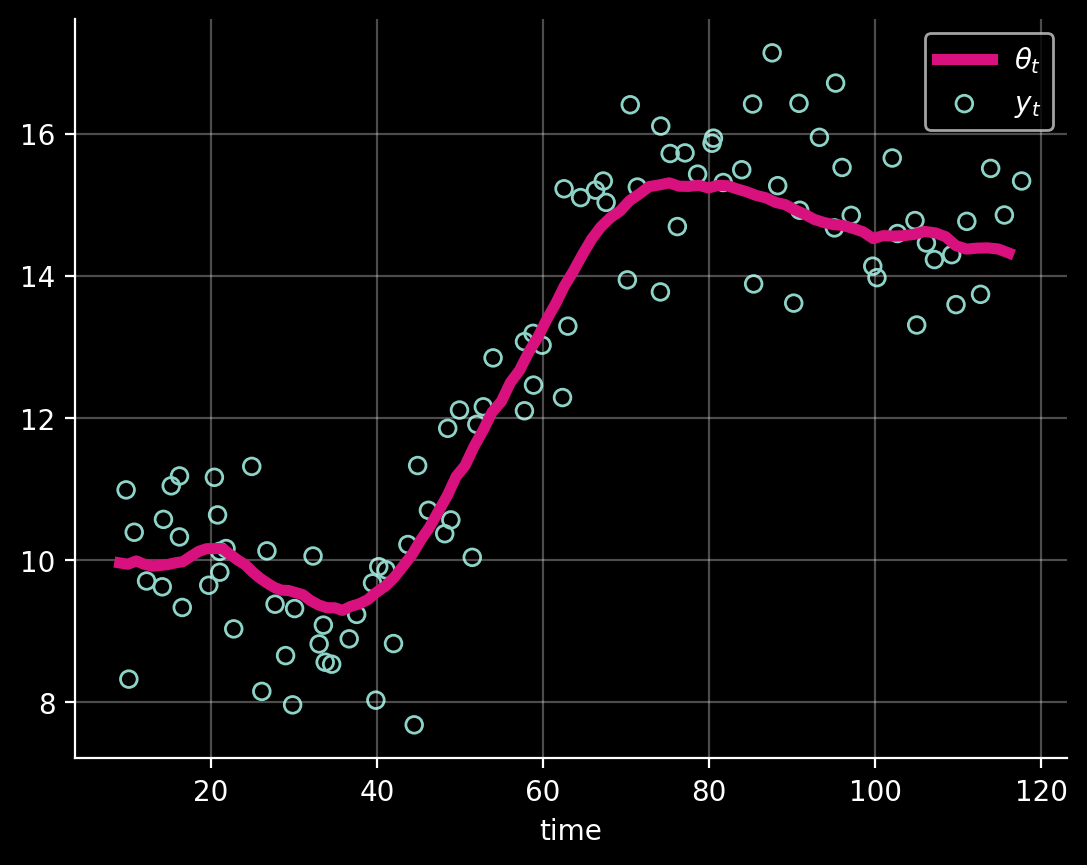

In [43]:
plt.plot(*latent_hist[:, :2].T, label=r"$\theta_t$", linewidth=4, color=acolors[0])
plt.scatter(*obs_hist.T, c="none", edgecolor=colors[0], label=f"$y_t$")
plt.legend()
plt.xlabel("time")
plt.grid(alpha=0.3)

In [44]:
agent = kf.LinearFilter(
    dynamics_weights,
    dynamics_covariance,
    emission_covariance
)

In [45]:
bel_init = agent.init_bel(initial_mean, cov=1.0)

In [46]:
bel, bel_hist = agent.scan(
    bel_init, obs_hist, emission_weights
)

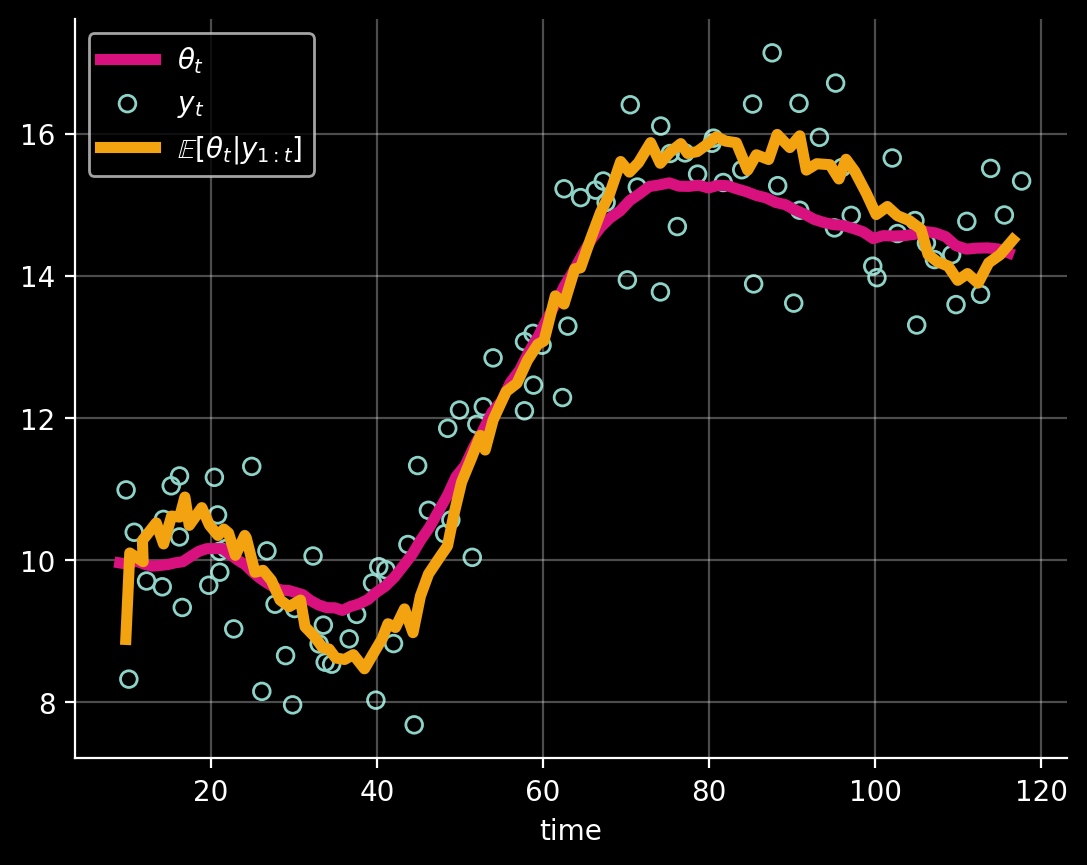

In [56]:
plt.plot(*latent_hist[:, :2].T, label=r"$\theta_t$", linewidth=4, color=acolors[0])
plt.scatter(*obs_hist.T, c="none", edgecolor=colors[0], label="$y_t$")
plt.plot(*bel_hist[:, :2].T, c=acolors[2], label=r"$\mathbb{E}[\theta_t \vert y_{1:t}]$", linewidth=4)
plt.legend()
plt.xlabel("time")
plt.grid(alpha=0.3)